In [6]:
import torch
import numpy as np
import random
import checkpoint
from dataset import SwitchDataset
from model import MLP
from plot import Plotter

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


def predictions(logits):
    """
    Compute the predictions from the model.
    Inputs:
        - logits: output of our model based on some input, tensor with shape=(batch_size, num_classes)
    Returns:
        - pred: predictions of our model, tensor with shape=(batch_size)
    """
    # TODO (part d): compute the predictions
    pred = torch.argmax(logits, dim=1)
    
    return pred


def accuracy(y_true, y_pred):
    """
    Compute the accuracy given true and predicted labels.
    Inputs:
        - y_true: true labels, tensor with shape=(num_examples)
        - y_pred: predicted labels, tensor with shape=(num_examples)
    Returns:
        - acc: accuracy, float
    """
    # TODO (part d): compute the accuracy
    acc = sum(yt == yp for yt, yp in zip(y_true, y_pred)) / len(y_true)
    
    return (acc * 100)


def _train_epoch(train_loader, model, criterion, optimizer):
    """
    Train the model for one iteration through the train set.
    """
    for i, (X, y) in enumerate(train_loader):
        # clear parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()


def _evaluate_epoch(plotter, train_loader, val_loader, model, criterion, epoch):
    """
    Evaluates the model on the train and validation set.
    """
    stat = []
    for data_loader in [val_loader, train_loader]:
        y_true, y_pred, running_loss = evaluate_loop(data_loader, model, criterion)
        total_loss = np.sum(running_loss) / y_true.size(0)
        total_acc = accuracy(y_true, y_pred)
        stat += [total_acc, total_loss]
    plotter.stats.append(stat)
    plotter.log_cnn_training(epoch)
    plotter.update_cnn_training_plot(epoch)


def evaluate_loop(data_loader, model, criterion=None):
    model.eval()
    y_true, y_pred, running_loss = [], [], []
    for X, y in data_loader:
        with torch.no_grad():
            output = model(X)
            output = output.reshape(4, 25)
            predicted = predictions(output.data)
            y_true.append(y)
            y_pred.append(predicted)
            if criterion is not None:
                running_loss.append(criterion(output, y).item() * X.size(0))
    model.train()
    y_true, y_pred = torch.cat(y_true), torch.cat(y_pred)
    return y_true, y_pred, running_loss


def train(config, dataset, model):
    # Data loaders
    train_loader, val_loader = dataset.train_loader, dataset.val_loader

    if 'use_weighted' not in config:
        # TODO (part d): define loss function
        criterion = torch.nn.CrossEntropyLoss()
    else:
        # TODO (part h): define weighted loss function
        weight = torch.tensor([1.0, 20.0])
        criterion = torch.nn.CrossEntropyLoss(weight=weight)
        
    # TODO (part d): define optimizer
    learning_rate = config['learning_rate']
    momentum = config['momentum']
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)

    # Attempts to restore the latest checkpoint if exists
    print('Loading model...')
    force = config['ckpt_force'] if 'ckpt_force' in config else False
    model, start_epoch, stats = checkpoint.restore_checkpoint(model, config['ckpt_path'], force=force)

    # Create plotter
    plot_name = config['plot_name'] if 'plot_name' in config else 'CNN'
    plotter = Plotter(stats, plot_name)

    # Evaluate the model
    _evaluate_epoch(plotter, train_loader, val_loader, model, criterion, start_epoch)

    # Loop over the entire dataset multiple times
    for epoch in range(start_epoch, config['num_epoch']):
        # Train model on training set
        _train_epoch(train_loader, model, criterion, optimizer)

        # Evaluate model on training and validation set
        _evaluate_epoch(plotter, train_loader, val_loader, model, criterion, epoch + 1)

        # Save model parameters
        checkpoint.save_checkpoint(model, epoch + 1, config['ckpt_path'], plotter.stats)

    print('Finished Training')

    # Save figure and keep plot open
    plotter.save_cnn_training_plot()
    plotter.hold_training_plot()



Loading model...
No saved model parameters found
Setting up interactive graph...


RuntimeError: Expected target size [4, 25], got [4, 5, 5]

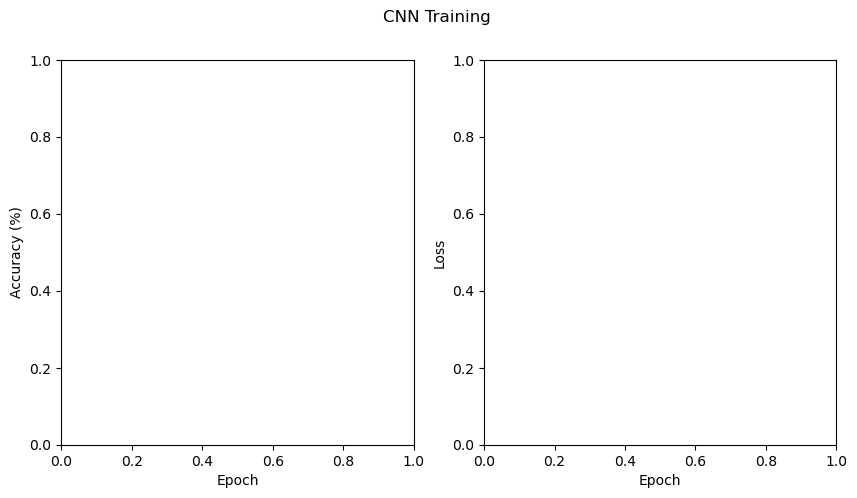

In [7]:
if __name__ == '__main__':
    # define config parameters for training
    config = {
        'batch_size': 4,
        'ckpt_path': 'checkpoints/mlp',  # directory to save our model checkpoints
        'num_epoch': 10,                 # number of epochs for training
        'learning_rate': 1e-3,           # learning rate
        'momentum': 0.9,                  # momentum 
    }
    # create dataset
    dataset = SwitchDataset(config['batch_size'], 800)
    # create model
    model = MLP()
    # train our model on dataset
    train(config, dataset, model)